In [67]:
import os
import zipfile

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Imputation libraries
import scprep # preprocessing
import saver
import magic

from scipy.stats import spearmanr

# Clustering libraries
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import silhouette_score, adjusted_rand_score, v_measure_score

# Step 0: Download the training data

In [5]:
path_data = "data/"
results_path = "results"
archive_name = "CarballoCastro_Alba.zip"

In [6]:
bulk_pancreas = pd.read_csv(os.path.join(path_data,"train_data","pancreas_bulk_train.csv")).set_index("level_0")
sc_pancreas = pd.read_csv(os.path.join(path_data,"train_data","pancreas_sc_train.csv")).set_index("Unnamed: 0")
sc_pancreas_metadata = pd.read_csv(os.path.join(path_data,"train_data","pancreas_sc_metadata_train.csv")).set_index("Source Name")

sc_pancreas_test = pd.read_csv(os.path.join(path_data,"test_data","pancreas_sc_test.csv")).set_index("Unnamed: 0")
sc_pancreas_metadata_test = pd.read_csv(os.path.join(path_data,"test_data","pancreas_sc_metadata_test_wocelltype.csv")).set_index("Source Name")

In [6]:
print(f"Number of patients in the train dataset {bulk_pancreas.shape[1]}")
print(f"Number of genes in the dataset {bulk_pancreas.shape[0]}")

assert bulk_pancreas.shape[0] == sc_pancreas.shape[0]
print(f"Number of cells in the train dataset {sc_pancreas.shape[1]}")

Number of patients in the train dataset 4
Number of genes in the dataset 25453
Number of cells in the train dataset 978


In [7]:
print(f"Number of cells in the test dataset {sc_pancreas_test.shape[1]}")

Number of cells in the test dataset 789


In [8]:
for patient in sc_pancreas_metadata.Sample.unique():
    print(f"Number of cells for {patient} is {sc_pancreas_metadata[sc_pancreas_metadata.Sample==patient].shape[0]}")

Number of cells for patient1 is 249
Number of cells for patient3 is 219
Number of cells for patient2 is 234
Number of cells for patient4 is 276


In [9]:
for dis in sc_pancreas_metadata.Disease.unique():
    df = sc_pancreas_metadata[sc_pancreas_metadata.Disease==dis]
    print(f"There are {df.Sample.nunique()} train patients with {dis}")

There are 2 train patients with type II diabetes mellitus
There are 2 train patients with normal


In [10]:
print(f"There are {df.Celltype.nunique()} different cell types in the dataset")
print(f"The different cells types are {df.Celltype.unique()}")

There are 11 different cell types in the dataset
The different cells types are ['delta cell' 'alpha cell' 'beta cell' 'PSC cell' 'endothelial cell'
 'gamma cell' 'co-expression cell' 'ductal cell' 'epsilon cell'
 'unclassified endocrine cell' 'acinar cell']


In [11]:
for patient in sc_pancreas_metadata_test.Sample.unique():
    print(f"Number of cells for {patient} is {sc_pancreas_metadata_test[sc_pancreas_metadata_test.Sample==patient].shape[0]}")

Number of cells for patient5 is 203
Number of cells for patient7 is 284
Number of cells for patient6 is 302


In [12]:
for dis in sc_pancreas_metadata_test.Disease.unique():
    df = sc_pancreas_metadata_test[sc_pancreas_metadata_test.Disease==dis]
    print(f"There are {df.Sample.nunique()} test patients with {dis}")

There are 1 test patients with normal
There are 2 test patients with type II diabetes mellitus


# Step 1: Perform the imputation

### Data preprocessing

* Filtering: we see that data is prefiltered
* Normalization: log transform with pseudocount
* Removing unexpressed genes? -> MAGIC recomienda pero según las guidelines no se debe eliminar ningún gen

/home/acarballocastro/.conda/envs/ML4G_Proj2/lib/python3.10/site-packages/scprep/plot/histogram.py:180: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.axvline(cutoff, color="red")
/home/acarballocastro/.conda/envs/ML4G_Proj2/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Axes: xlabel='Library size', ylabel='Number of cells'>

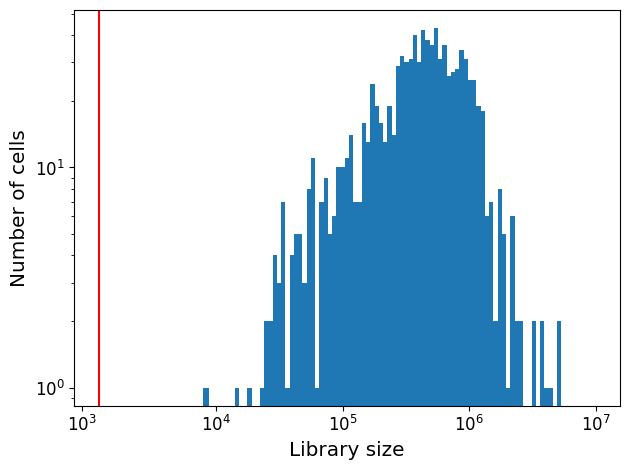

In [7]:
scprep.plot.plot_library_size(sc_pancreas.transpose(), cutoff=2000)

In [8]:
sc_pancreas_norm = scprep.normalize.library_size_normalize(sc_pancreas.transpose())
sc_pancreas_norm = scprep.transform.sqrt(sc_pancreas_norm)

### Imputation using MAGIC

In [9]:
magic_op = magic.MAGIC()

In [10]:
pancreas_magic = magic_op.fit_transform(sc_pancreas_norm)
pancreas_magic.head()

Calculating MAGIC...
  Running MAGIC on 978 cells and 25453 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


/home/acarballocastro/.conda/envs/ML4G_Proj2/lib/python3.10/site-packages/magic/magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculated PCA in 5.10 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.14 seconds.
    Calculating affinities...
    Calculated affinities in 0.07 seconds.
  Calculated graph and diffusion operator in 5.35 seconds.
  Running MAGIC with `solver='exact'` on 25453-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 0.58 seconds.
Calculated MAGIC in 6.01 seconds.


Unnamed: 0,SGIP1,AZIN2,CLIC4,AGBL4,NECAP2,SLC45A1,TGFBR3,DBT,RFWD2,C1orf21,...,LOC389831,MGC70870,KIR2DS5,KIR2DL5A,KIR3DS1,KIR2DL5B,KIR2DS2,KIR2DS1,KIR2DL2,KIR2DS3
patient1_A10,0.003604,0.008971,0.598219,0.004887,0.644103,0.000959,0.069828,0.275668,0.583366,0.477737,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
patient1_A12,0.000024,0.092730,0.073481,0.016529,0.130206,0.032678,0.001726,0.132666,0.120153,0.336323,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
patient1_A13,0.163296,0.148979,0.133651,0.114099,0.314314,0.058043,0.001205,0.291347,0.131077,0.181231,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
patient1_A15,0.147452,0.128442,0.155374,0.087904,0.319700,0.057098,0.002018,0.327191,0.178084,0.212150,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
patient1_A17,0.110672,0.118867,0.099777,0.105441,0.391329,0.062556,0.002105,0.282515,0.275805,0.185374,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
bulkified_magic = sc_pancreas_metadata.join(pancreas_magic, on="Source Name").groupby('Sample', as_index=False).mean().transpose().tail(-1)
bulkified_magic.columns = ["patient1","patient2","patient3","patient4"]
bulkified_magic.index = sc_pancreas.index

### Spearman

In [12]:
# MAGIC
corr, pval = spearmanr(bulk_pancreas, bulkified_magic)
spearman = corr.mean()
spearman

0.9594169542685492

# Step 2: Perform clustering 

### Clustering on MAGIC transformed data

In [14]:
# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=0)
pancreas_tsne = tsne.fit_transform(pancreas_magic)

In [49]:
# Perform K-means clustering
kmeans = KMeans(n_clusters=11, random_state=0)
clusters = kmeans.fit_predict(pancreas_tsne) + 1 # Ensure clusters are labeled 1-11. 1-indexed

/home/acarballocastro/.conda/envs/ML4G_Proj2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


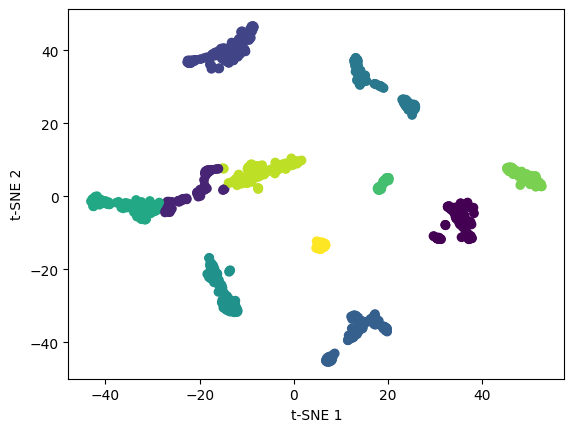

In [50]:
# Plot t-SNE visualization with cluster assignments
plt.scatter(pancreas_tsne[:,0], pancreas_tsne[:,1], c=clusters)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

In [52]:
cluster_labels = pd.DataFrame(data = {'index': sc_pancreas.columns, 'cluster': clusters})
cluster_labels

,index,cluster
0,patient1_A10,4
1,patient1_A12,7
2,patient1_A13,3
3,patient1_A15,3
4,patient1_A17,3
...,...,...
973,patient4_P5,10
974,patient4_P6,10
975,patient4_P7,10
976,patient4_P8,10


### PCA

In [33]:
pca = PCA(n_components=50)
pancreas_pca = pca.fit_transform(pancreas_magic)

In [45]:
# Print the explained variance ratio for each principal component
# print('Explained variance ratio:', pca.explained_variance_ratio_)

# Print the total explained variance
print('Total explained variance:', np.sum(pca.explained_variance_ratio_))

Total explained variance: 0.9989323966146435


In [53]:
PCA = pd.DataFrame(data = pancreas_pca, columns = ["PC"+str(i+1) for i in range(50)])
PCA.insert(loc=0, column='index', value=sc_pancreas.columns)

### Evaluation metrics

In [76]:
true_labels = LabelEncoder().fit(sc_pancreas_metadata['Celltype'])
true_labels = true_labels.transform(sc_pancreas_metadata['Celltype'])
true_labels # NO SE PORQUE PERO ESTO ME DA 12 CLASES en vez de 11

array([ 2,  3, 10, 10, 10, 10,  3, 10,  3,  6, 10,  3,  3,  3, 10,  3, 10,
        3,  3, 10, 10,  3, 10, 10, 12, 10, 10,  4,  3,  7,  8,  6,  2, 10,
        3,  3,  5,  3,  4,  3, 10,  3,  3,  6,  3, 10,  3,  3, 10, 10, 10,
        3,  3, 10, 10, 10,  3,  3,  3, 12,  4,  3,  3, 10, 10,  4,  4, 10,
        3, 10,  3,  3,  3,  4,  3, 10,  3, 10, 10, 10,  2,  3, 10,  3, 10,
       10,  3, 10,  6,  1,  3, 10, 10,  3,  3,  3,  3,  3,  3,  3, 10,  3,
        3,  3, 10,  3,  3,  3, 10, 10, 10, 10, 10, 10,  3,  3,  7,  3,  3,
        3,  3,  4, 10,  3,  6,  4,  3,  3, 10,  3, 10, 10,  3,  3,  3,  3,
        3,  3,  3,  3,  2, 10,  3,  3,  3,  3,  6,  3,  2,  3,  3,  3, 10,
        3, 10, 10,  3, 10,  2,  3,  3,  3,  2, 10,  3,  3,  3,  3,  3, 10,
       10,  3,  6, 10,  2, 10,  3,  3,  3,  3,  3, 10,  3,  3,  3,  3,  3,
       10,  3,  3,  3,  3,  3,  3,  3,  3, 10,  3,  3,  3,  3,  9,  3,  3,
        4,  3,  3,  3, 10,  3,  3,  3, 10,  6,  3,  3,  3,  3,  3,  3,  3,
        3, 10,  4,  3,  3

In [77]:
ssc = silhouette_score(pancreas_pca, clusters)
print('Silhouette score:', ssc)

ari = adjusted_rand_score(true_labels, clusters)
print('Adjusted Rand Index:', ari)

v_measure = v_measure_score(true_labels, clusters)
print('V-Measure score:', v_measure)

performance = (1/3)*(ssc + ari + v_measure)
print('Performance:', performance)

Silhouette score: 0.48368456857512004
Adjusted Rand Index: 0.5072908405032788
V-Measure score: 0.7738777854984207
Performance: 0.5882843981922732


# Step 3: Predict on the test data

Cuando decidamos qué tecnicas de imputación y clustering son mejores, hacerlo en los datos de test.

# Step 4: Save the required files

In [ ]:
# bulkified should be a DataFrame containing the "bulkified" version of the imputed data
# bulkified.columns = ["patient5","patient6","patient7"]
# bulkified.index = sc_pancreas_test.index

In [ ]:
# assert all(bulkified.columns == ["index","patient5","patient6","patient7"])
# assert all(bulkified["index"] == sc_pancreas_test.index)

In [ ]:
# cluster_labels should be a DataFrame containing the cluster labels for each cell
# cluster_labels.columns = ["index", "cluster"]
# cluster_labels["index"] = sc_pancreas_test.columns

In [ ]:
# assert all(cluster_labels.columns == ["index","cluster"])
# assert all(cluster_labels["index"] == sc_pancreas_test.columns)

In [ ]:
# PCA should be a DataFrame containing the coordinates of each cell in the PCA transformed space for the 50 first PCs
# PCA.columns = ["index", "PC1", "PC2", ..., "PC50"]
# PCA["index"] = sc_pancreas_test.columns

In [ ]:
# assert all(PCA.columns == ["index"] + ["PC"+str(i+1) for i in range(50)])
# assert all(PCA["index"] == sc_pancreas_test.columns)

In [ ]:
# with zipfile.ZipFile(os.path.join(results_path, archive_name), "x") as zf:
#     with zf.open(f"imputed_bulkified.csv", "w") as buffer:
#         bulkified.to_csv(buffer)
#     with zf.open(f"cluster_membership.csv", "w") as buffer:
#         cluster_labels.to_csv(buffer)
#     with zf.open(f"PCA.csv", "w") as buffer:
#         PCA.to_csv(buffer)
#     zf.close()

In [ ]:
# archive = zipfile.ZipFile(os.path.join(results_path, archive_name))
# assert all(
#         [
#             i in archive.namelist()
#             for i in [
#                 "imputed_bulkified.csv",
#                 "cluster_membership.csv",
#                 "PCA.csv",
#             ]
#         ]
#     )